In [1]:
!nvidia-smi

Sun Apr 10 23:08:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
#install libraries
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17.3
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.3 kB/s 
     |████████████████████████████████| 6.6 MB 40.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
     |████████████████████████████████| 20.0 MB 31.4 MB/s 
  Attempting uninstal

     |████████████████████████████████| 269 kB 29.4 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=fa2cd375eaf9f2964e48ddb74c14cf944d84e7e9fe7fdbb043f75a5ad67bd510
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-2ofmk09r
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-2ofmk09r
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264900 sha256=2d164710f7a7ad15fc0f544568c310480646695287ddee632db10d7abac3ac8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i872y92t/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully buil

**Build the Dataset**

In [4]:
# imports
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import os
import PIL

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [5]:
# our data directories
!tree   Weapon-detection-1 -L 2

Weapon-detection-1 [error opening dir]

0 directories, 0 files


# Preparing the Dataset
- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HAAZzUmIip5OvdPutJ9O")
project = rf.workspace("alon-barak").project("weapon-detection-dp9bo")
dataset = project.version(1).download("yolov5")


#YOLOv5 Setup

Follow the next steps in order to properly setup the project in your enviorment:
 - clone the github repository (done in the next cell).
 - carefully move the 'weapon-detection-1' folder into the new 'yolov5' folder.
 - from the 'weapon-detection-1' folder, move the 'data.yaml' file to "yolov5/data/" folder.
 - open the "yolov5/models/yolov5x.yaml" and change the "nc" variable from 80 to 1 (number of classes) and save the changes. 

In [ ]:
# cloning the git repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout 741fac815e366d74eed020efb8c68a23828ee3e9

In [8]:
# show the dimensions of the images in the dataset
img = cv2.imread('/content/yolov5/Weapon-detection-1/train/images/107_jpeg.rf.22d3c90341d7af62ed4cb51f334ce3dc.jpg', cv2.IMREAD_UNCHANGED)
dimensions = img.shape
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (460, 460, 3)
Image Height       :  460
Image Width        :  460
Number of Channels :  3


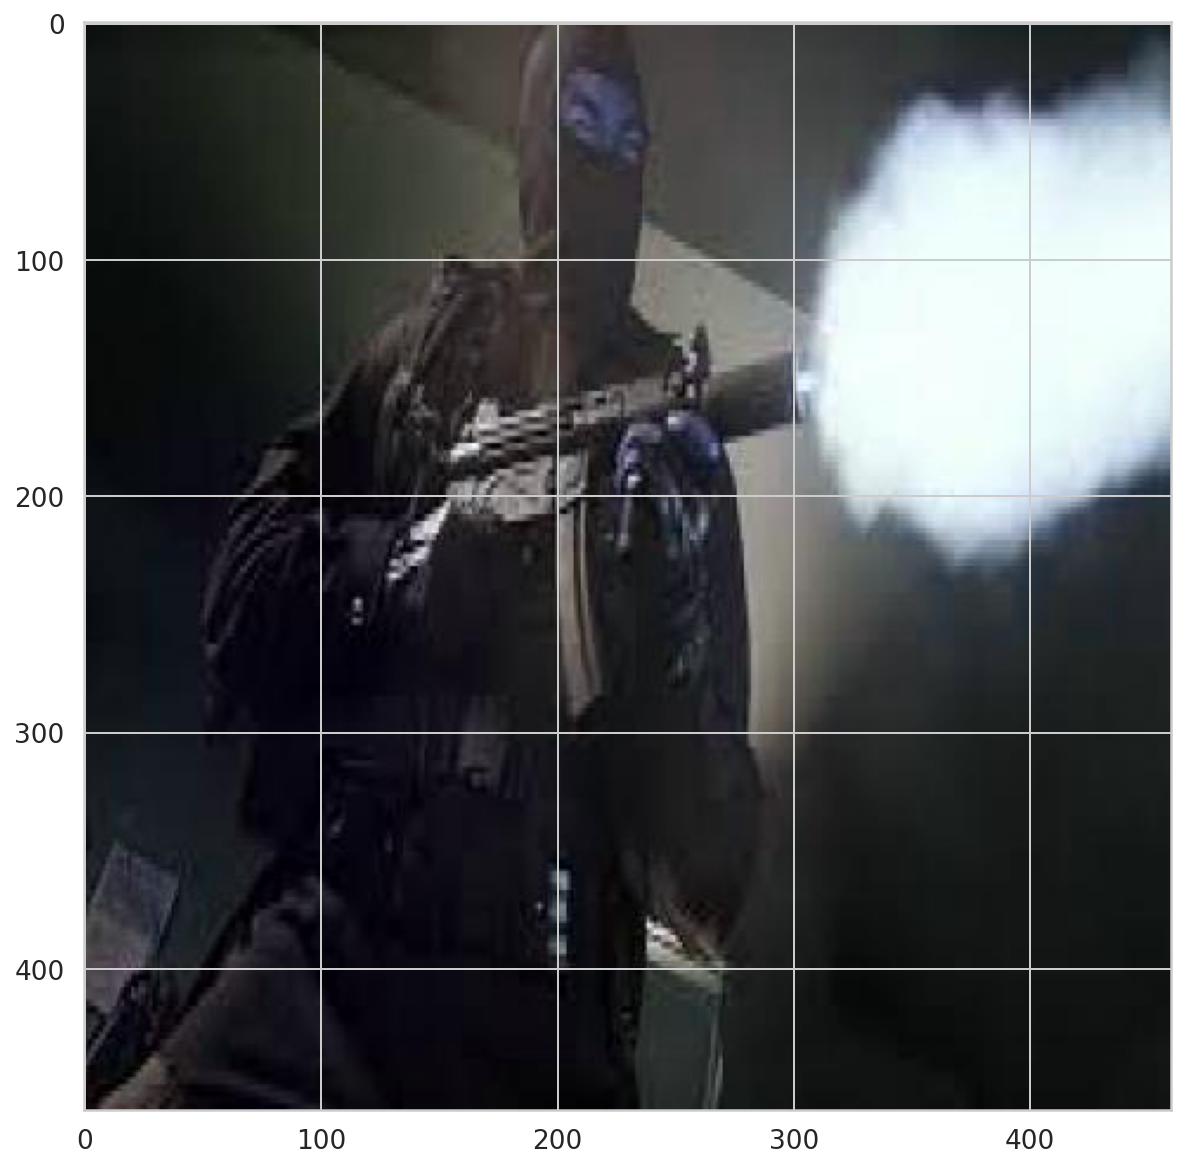

In [9]:
img = cv2.imread('/content/yolov5/Weapon-detection-1/train/images/107_jpeg.rf.22d3c90341d7af62ed4cb51f334ce3dc.jpg', cv2.IMREAD_UNCHANGED)
plt.imshow(img)

In [10]:
# now the data is in YOLO format [num_of_classes_in_pic [x_center, y_center, width, height]]
!cat /content/yolov5/Weapon-detection-1/train/labels/101_jpeg.rf.862e32bcad46dd649654db9c788a5c47.txt

0 0.5880434782608696 0.34347826086956523 0.15108695652173912 0.3684782608695652

Setting training configurations to our YOLOv5 Model. <br>
Each batch will contain 4 images. <br>
Each epoch will contain 30 images. <br>
Notice that I'm using the YOLOv5x model, results might be different on different modles.

In [12]:
!python train.py --img 480 --batch 4 --epochs 30 --data ./data/data.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt --name yolov5x_weapon

train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=4, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_weapon, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 20 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-104-g741fac8 torch 1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, a

# Scores

we can see that YOLOv5x preduce good results using only 500 images (RGB & BW).<br>
It took the model about 15 minutes to train the network and preduce 0.764 accuracy rate at its best iteration. 

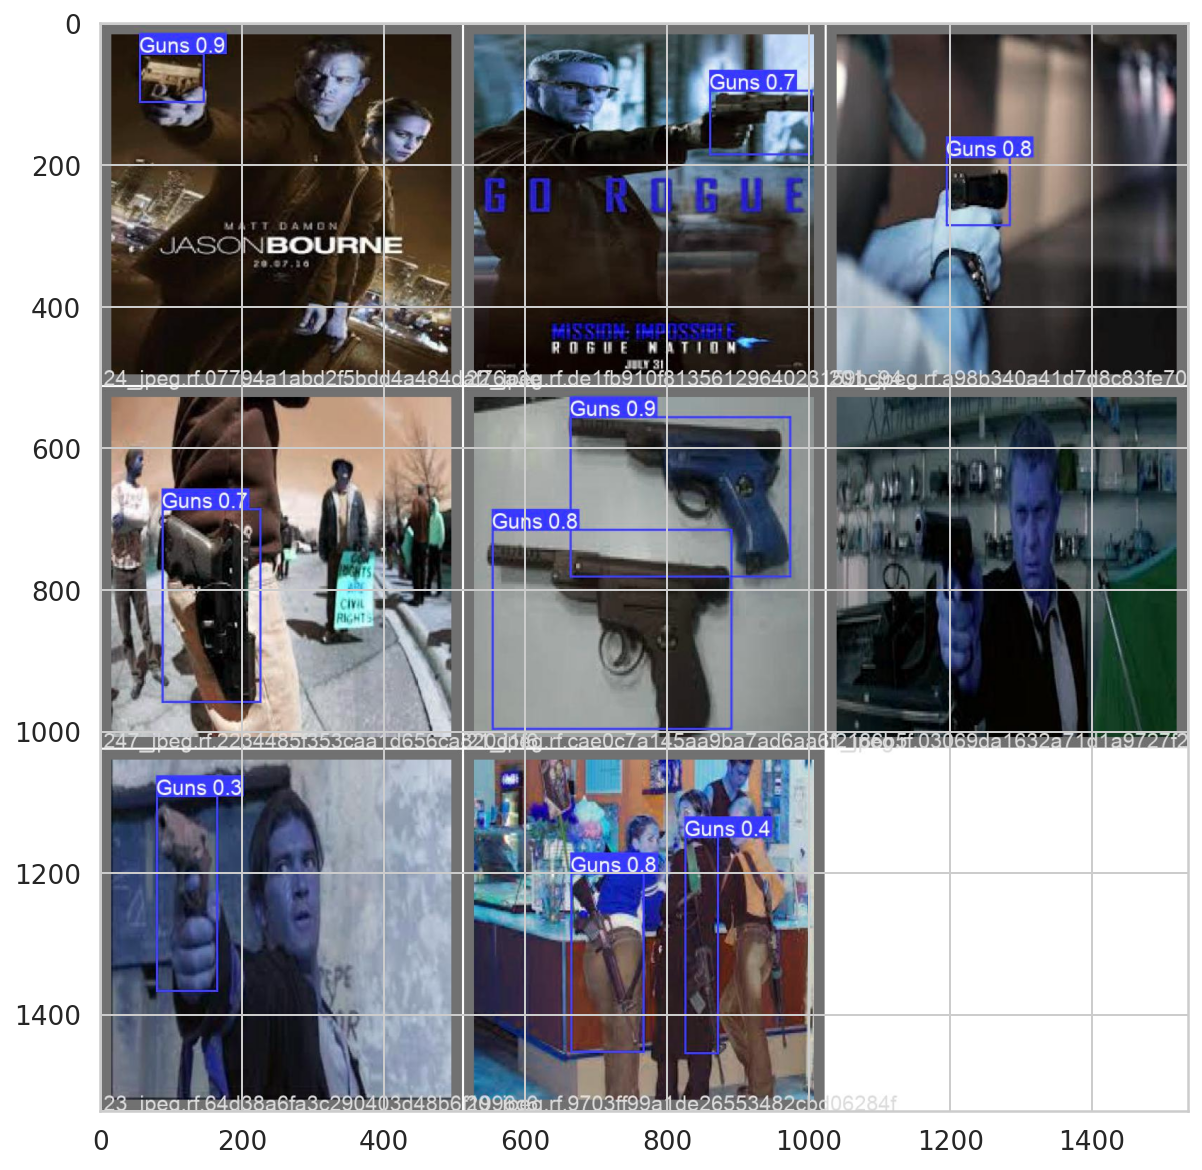

In [14]:
# view some predictions
img = cv2.imread('/content/yolov5/runs/train/yolov5x_weapon2/val_batch2_pred.jpg', cv2.IMREAD_UNCHANGED)
plt.imshow(img)